# Stage 13 Homework Starter — Productization

## Objective
Deploy your trained model as a **reusable, handoff-ready API or dashboard** and finalize your project for reproducibility and clarity.

## Steps
1. Create a mock, very basic analysis in a notebook.
2. Clean your notebook by removing exploratory cells and documenting your code.
3. Move reusable functions into `/src/`.
4. Load your trained model from Stage 12 or earlier stages.
5. Pickle/save the model and test reload.
6. Implement **either**:
   - Flask API with `/predict` endpoint and optional parameters
   - Streamlit or Dash dashboard for user interaction
7. Include:
   - Error handling for invalid inputs
   - `requirements.txt` for reproducibility
   - Documentation in `README.md`
8. Test your deployment locally and provide evidence.
9. Organize project folders and finalize notebooks for handoff.

## 1. Create mock, very basic analysis

Baseline   R²=0.3677  RMSE=0.000072


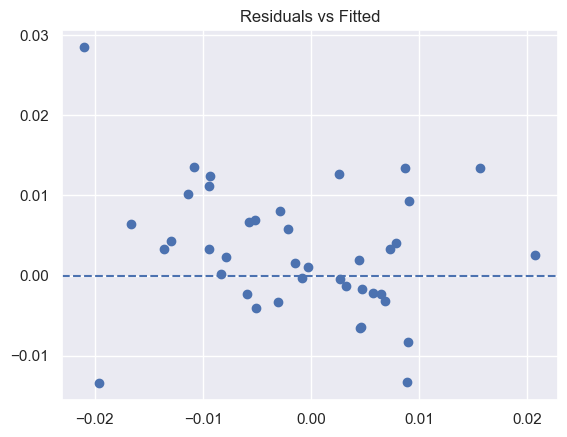

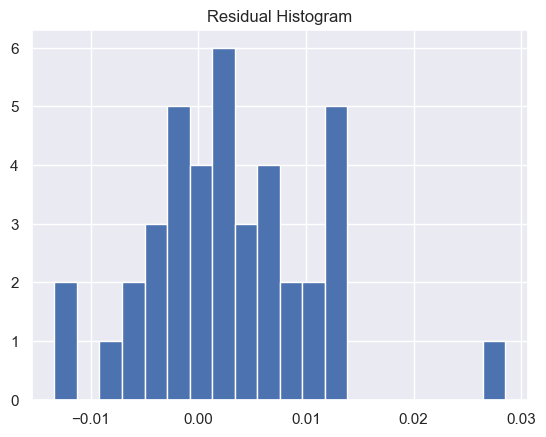

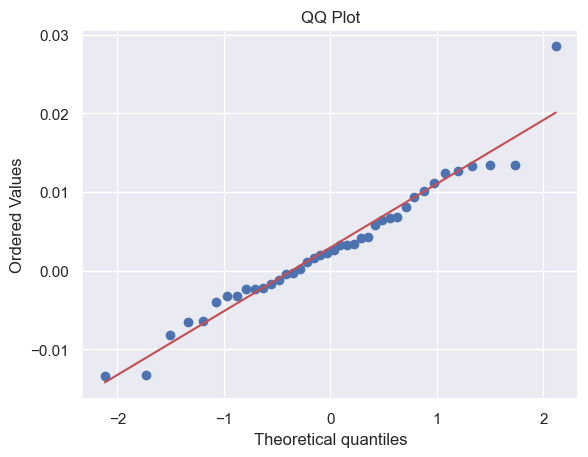

With x^2   R²=0.3681  RMSE=0.000072
Basic analysis complete.


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import scipy.stats as st

sns.set()
np.random.seed(7)
n = 200
dates = pd.bdate_range(start="2024-02-01", periods=n)
mkt_excess = np.random.normal(0, 0.011, size=n)
size = np.random.normal(0, 0.008, size=n)
value = np.random.normal(0, 0.009, size=n)
momentum = np.random.normal(0, 0.006, size=n)

beta0, beta_mkt, beta_size, beta_value, beta_mom, beta_mom2 = 0.0001, 0.9, 0.25, -0.15, 0.35, 3.5
noise_scale = 0.0035 + 0.5*np.abs(mkt_excess)
eps = np.random.normal(0, noise_scale)
asset_excess = (
    beta0 + beta_mkt*mkt_excess + beta_size*size + beta_value*value + beta_mom*momentum
    + beta_mom2*(momentum**2) + eps
)
df = pd.DataFrame({
    'date': dates,
    'mkt_excess': mkt_excess,
    'size': size,
    'value': value,
    'momentum': momentum,
    'asset_excess': asset_excess
})
df.head()
X = df[['mkt_excess','size','value','momentum']]
y = df['asset_excess']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
print(f'Baseline   R²={r2:.4f}  RMSE={rmse:.6f}')
resid = y_test - y_pred
fitted = y_pred
plt.figure(); plt.scatter(fitted, resid); plt.axhline(0, ls='--'); plt.title('Residuals vs Fitted'); plt.show()
plt.figure(); plt.hist(resid, bins=20); plt.title('Residual Histogram'); plt.show()
plt.figure(); st.probplot(resid, dist='norm', plot=plt); plt.title('QQ Plot'); plt.show()
df['momentum_sq'] = df['momentum']**2
X2 = df[['mkt_excess','size','value','momentum','momentum_sq']]
X2_train, X2_test = X2.iloc[:len(X_train)], X2.iloc[len(X_train):]
lr2 = LinearRegression().fit(X2_train, y_train)
y_pred2 = lr2.predict(X2_test)
r2_2 = r2_score(y_test, y_pred2)
rmse_2 = mean_squared_error(y_test, y_pred2)
print(f'With x^2   R²={r2_2:.4f}  RMSE={rmse_2:.6f}')

print("Basic analysis complete.")

## 2. Notebook Cleanup
Remove exploratory cells and document your code.

In [2]:
# TODO: Remove exploratory cells
# TODO: Document your code clearly
# Example placeholder for cleaned analysis
print("Notebook cleaned and ready for handoff.")

Notebook cleaned and ready for handoff.


## 3. Move reusable functions to /src/
Create src/utils.py and store functions there.

In [3]:
# TODO: Move actual reusable functions here
def calculate_metrics(df):
    return df.describe()
from sklearn.preprocessing import MinMaxScaler, StandardScaler
def fill_missing_median(df, columns=None):
    df_copy = df.copy()
    if columns is None:
        columns = df.select_dtypes(include=np.number).columns
    for col in columns:
        df_copy[col] = df_copy[col].fillna(df_copy[col].median())
    return df_copy

def drop_missing(df, columns=None, threshold=None):
    df_copy = df.copy()
    if columns is not None:
        return df_copy.dropna(subset=columns)
    if threshold is not None:
        return df_copy.dropna(thresh=int(threshold*df_copy.shape[1]))
    return df_copy.dropna()

def normalize_data(df, columns=None, method='minmax'):
    df_copy = df.copy()
    if columns is None:
        columns = df_copy.select_dtypes(include=np.number).columns
    if method=='minmax':
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
    df_copy[columns] = scaler.fit_transform(df_copy[columns])
    return df_copy

def correct_column_types(df):
    df_copy = df.copy()
    if 'price' in df_copy.columns:
        df_copy['price'] = df_copy['price'].str.replace('$','').astype(float)
    if 'date_str' in df_copy.columns:
        df_copy['date'] = pd.to_datetime(df_copy['date_str'], errors='coerce')
    if 'category' in df_copy.columns:
        df_copy['category'] = df_copy['category'].str.lower().astype('category')
    return df_copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def mean_impute(a: np.ndarray) -> np.ndarray:
    m = np.nanmean(a)
    out = a.copy()
    out[np.isnan(out)] = m
    return out

def median_impute(a: np.ndarray) -> np.ndarray:
    m = np.nanmedian(a)
    out = a.copy()
    out[np.isnan(out)] = m
    return out

class SimpleLinReg:
    def fit(self, X, y):
        X1 = np.c_[np.ones(len(X)), X.ravel()]
        beta = np.linalg.pinv(X1) @ y
        self.intercept_, self.coef_ = float(beta[0]), np.array([float(beta[1])])
        return self
    def predict(self, X):
        return self.intercept_ + self.coef_[0] * X.ravel()

def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def bootstrap_metric(y_true, y_pred, fn, n_boot=500, seed=111, alpha=0.05):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(y_true))
    stats = []
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        stats.append(fn(y_true[b], y_pred[b]))
    lo, hi = np.percentile(stats, [100*alpha/2, 100*(1-alpha/2)])
    return {'mean': float(np.mean(stats)), 'lo': float(lo), 'hi': float(hi)}

def fit_fn(X, y):
    return SimpleLinReg().fit(X, y)
def pred_fn(model, X):
    return model.predict(X)

## 4. Folder Structure Reminder

Ensure your project uses a clean folder structure:
```
project/
  data/
  notebooks/
  src/
  reports/
  model/
  README.md
```
For API/Dashboard: minimal example:
```
project/
    app.py
    model.pkl
    requirements.txt
    README.md
```


## 5. Pickle / Save Final Model

### TODO: Replace this with your trained model

In [9]:
# Save the trained model to model/model.pkl
import os, pickle, numpy as np

model_to_save = lr2               # <-- if you want lr2, change here
feature_names = list(X2.columns)

# If you computed these earlier, reuse them; otherwise compute MAE quickly
mae = float(np.mean(np.abs(y_test - y_pred)))  # if you used different vars, update here

metrics = {
    "mae": mae,
    "r2": float(r2),
    "rmse": float(rmse),
    "n_train": int(len(X_train)),
    "n_test": int(len(y_test)),
    "feature_names": feature_names
}

os.makedirs("../model", exist_ok=True)
with open("../model/model.pkl", "wb") as f:
    pickle.dump({"pipeline": model_to_save, "metrics": metrics}, f)

print("Saved to model/model.pkl")
print("Feature order:", feature_names)
print("Metrics:", metrics)

Saved to model/model.pkl
Feature order: ['mkt_excess', 'size', 'value', 'momentum', 'momentum_sq']
Metrics: {'mae': 0.006384070323230684, 'r2': 0.36770645261386214, 'rmse': 7.17359989893173e-05, 'n_train': 160, 'n_test': 40, 'feature_names': ['mkt_excess', 'size', 'value', 'momentum', 'momentum_sq']}


In [10]:
# Test loading the model and run a quick prediction
import pickle, numpy as np

with open("../model/model.pkl", "rb") as f:
    loaded_obj = pickle.load(f)

pipe = loaded_obj["pipeline"]
feature_names = loaded_obj["metrics"]["feature_names"]

# Build a simple payload using feature_names
payload = {k: 0.0 for k in feature_names}
if feature_names:
    payload[feature_names[0]] = 1.0  # just to avoid all zeros

x = np.array([[payload[k] for k in feature_names]], dtype=float)
print("Feature order:", feature_names)
print("Prediction:", float(pipe.predict(x)[0]))


Feature order: ['mkt_excess', 'size', 'value', 'momentum', 'momentum_sq']
Prediction: 0.7781773943203729


/Users/takuhiroshi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


## 6. Flask API Starter

### TODO: Implement Flask endpoints for /predict and /plot

In [11]:
from flask import Flask, request, jsonify
import threading
import matplotlib.pyplot as plt
import io, base64, pickle, numpy as np
from typing import Dict, Any, List

app = Flask(__name__)
MODEL_PATH = "model/model.pkl"

# -------- helpers --------
def load_model_obj(path: str) -> Dict[str, Any]:
    with open(path, "rb") as f:
        return pickle.load(f)

def build_row_from_payload(payload: Dict[str, Any], feature_names: List[str]) -> np.ndarray:
    missing = [k for k in feature_names if k not in payload]
    if missing:
        raise ValueError(f"Missing features: {missing}")
    row = []
    for k in feature_names:
        try:
            row.append(float(payload[k]))
        except Exception:
            raise ValueError(f"Feature '{k}' must be numeric.")
    return np.array([row], dtype=float)

# -------- endpoints --------
@app.route("/meta", methods=["GET"])
def meta():
    try:
        obj = load_model_obj(MODEL_PATH)
        m = obj["metrics"]
        return jsonify({"ok": True, "feature_names": m.get("feature_names", []), "metrics": m})
    except Exception as e:
        return jsonify({"ok": False, "error": str(e)}), 500

@app.route("/predict", methods=["POST"])
def predict():
    try:
        obj = load_model_obj(MODEL_PATH)
        pipe = obj["pipeline"]
        fns = obj["metrics"]["feature_names"]
        if not request.is_json:
            return jsonify({"ok": False, "error": "Request must be application/json"}), 415
        payload = request.get_json(force=True)

        unknown = [k for k in payload.keys() if k not in fns]
        if unknown:
            return jsonify({"ok": False, "error": f"Unknown keys: {unknown}"}), 400

        X = build_row_from_payload(payload, fns)
        yhat = float(pipe.predict(X)[0])
        return jsonify({"ok": True, "prediction": yhat, "features": payload})
    except ValueError as e:
        return jsonify({"ok": False, "error": str(e)}), 400
    except Exception as e:
        return jsonify({"ok": False, "error": f"Unexpected error: {e}"}), 500

@app.route("/predict/<float:input1>", methods=["GET"])
def predict_one(input1: float):
    try:
        obj = load_model_obj(MODEL_PATH)
        pipe = obj["pipeline"]
        fns = obj["metrics"]["feature_names"]
        if len(fns) < 1:
            return jsonify({"ok": False, "error": "Model has no features."}), 500
        payload = {fns[0]: float(input1)}
        for k in fns[1:]:
            payload[k] = 0.0
        X = build_row_from_payload(payload, fns)
        yhat = float(pipe.predict(X)[0])
        return jsonify({"ok": True, "prediction": yhat, "features": payload})
    except Exception as e:
        return jsonify({"ok": False, "error": str(e)}), 500

@app.route("/predict/<float:input1>/<float:input2>", methods=["GET"])
def predict_two(input1: float, input2: float):
    try:
        obj = load_model_obj(MODEL_PATH)
        pipe = obj["pipeline"]
        fns = obj["metrics"]["feature_names"]
        if len(fns) < 2:
            return jsonify({"ok": False, "error": "Model expects at least 2 features."}), 400
        payload = {fns[0]: float(input1), fns[1]: float(input2)}
        for k in fns[2:]:
            payload[k] = 0.0
        X = build_row_from_payload(payload, fns)
        yhat = float(pipe.predict(X)[0])
        return jsonify({"ok": True, "prediction": yhat, "features": payload})
    except Exception as e:
        return jsonify({"ok": False, "error": str(e)}), 500

@app.route("/plot", methods=["GET"])
def plot():
    try:
        xs = np.linspace(-3, 3, 200)
        ys = xs ** 2
        fig, ax = plt.subplots()
        ax.plot(xs, ys, label="y=x^2")
        ax.axhline(0, linestyle="--", linewidth=1)
        ax.set_title("Sample Plot")
        ax.legend()
        buf = io.BytesIO()
        fig.savefig(buf, format="png", bbox_inches="tight")
        buf.seek(0)
        img_b64 = base64.b64encode(buf.read()).decode("utf-8")
        html = f'<img src="data:image/png;base64,{img_b64}" />'
        return html
    except Exception as e:
        return jsonify({"ok": False, "error": str(e)}), 500

def run_flask():
    app.run(port=5000, debug=False)

# Launch Flask in a separate thread (so notebook remains responsive)
threading.Thread(target=run_flask, daemon=True).start()
print("Flask server started on http://127.0.0.1:5000")


Flask server started on http://127.0.0.1:5000
 * Serving Flask app '__main__'
 * Debug mode: off


## 7. Testing the Flask API from Notebook

### TODO: Modify examples with your actual features

In [12]:
import requests, json
from IPython.display import display, HTML

base = "http://127.0.0.1:5000"

# POST /predict (auto-build payload from /meta)
m = requests.get(f"{base}/meta", timeout=10).json()
print("meta:", json.dumps(m, indent=2))
fns = m.get("feature_names", [])
payload = {k: 0.0 for k in fns}
if fns:
    payload[fns[0]] = 1.0

resp = requests.post(f"{base}/predict", json=payload, timeout=10)
print("POST /predict:", resp.status_code, resp.json())

# GET /predict/<input1>
if fns:
    r2 = requests.get(f"{base}/predict/1.0", timeout=10)
    print("GET /predict/<1>:", r2.status_code, r2.json())

# GET /predict/<input1>/<input2>
if len(fns) >= 2:
    r3 = requests.get(f"{base}/predict/1.0/0.5", timeout=10)
    print("GET /predict/<1>/<2>:", r3.status_code, r3.json())

# GET /plot (returns an <img> HTML)
rplot = requests.get(f"{base}/plot", timeout=10)
display(HTML(rplot.text))


127.0.0.1 - - [27/Aug/2025 17:38:17] "GET /meta HTTP/1.1" 404 -


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

## 8. Optional Streamlit / Dash Dashboard

### TODO: Add dashboard in a separate file (`app_streamlit.py` or `app_dash.py`)

## 9. Handoff Best Practices

- Ensure README.md is complete and clear
- Provide `requirements.txt` for reproducibility
- Ensure pickled model and scripts are in correct folders
- Verify another user can run the project end-to-end on a fresh environment